# Why and When Attention Matters in Reinforcement Learning
> "Using RLlib and AttentionNet to master environments with stateless observations, here, stateless CartPole."

- hide: true
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [python, gym, ray, rllib, tensorflow, machine learning, reinforcement learning, sequence, attention]
- image: images/cartpole.jpg

In reinforcement learning (RL), the RL agent typically selects a suitable action based on the last observation.
In many practical environments, the full state can only be observed partially,
such that important information may be missing when just considering the last observation.
This blog post covers options for dealing with missing and only partially observed state,
e.g., considering a *sequence* of last observations and applying *self-attention* to this sequence.


## Example: The CartPole Gym Environment

As an example, consider the popular [OpenAI Gym CartPole environment](https://gym.openai.com/envs/CartPole-v1/).
Here, the task is to move a cart left or right in order to balance a pole on the cart as long as possible.

![OpenAI Gym CartPole-v1 Environment](attention/cartpole.gif "OpenAI Gym CartPole-v1 Environment")

In the normal [`CartPole-v1` environment](https://gym.openai.com/envs/CartPole-v1/), the RL agent observes four scalar values ([defined here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py#L26:L32)):
* The cart position, i.e., where the cart currently is.
* The cart velocity, i.e., how fast the cart is currently moving and in which direction (can be positive or negative).
* The pole angle, i.e., how tilted the pole currently is and in which direction.
* The pole angular velocity, i.e., how fast the pole is currently moving and in which direction.

All four observations are important to decide whether the cart should move left or right.

Now, assume the RL agent only has access to an instant snapshot of the cart and the pole (e.g., through a photo/raw pixels)
and can neither observe cart velocity nor pole angular velocity.
In this case, the RL agent does not know whether the pole is currently swinging to one side and cannot properly balance the pole.
How to deal with this problem of missing state (here, cart and pole velocity)?


## Options for Dealing With Missing State

There are different options for dealing with missing state, e.g., missing velocity in the CartPole example:

1. Add the missing state explicitly, e.g., measure and observe velocity. Note that this may require installing extra sensors or may even be infeasible in some scenarios.
2. Ignore the missing state, i.e., just rely on the available, partial observations. Depending on the missing state, this may be problematic and keep the agent from learning.
3. Keep track of a sequence of the last observations. By observing the cart position and pole angle over time, the agent can implicitly derive their velocity. There are different ways to deal with this sequence:
   1. Just use the sequence as is for a standard multi-layer perceptron (MLP)/dense feedforward neural network.
   2. Feed the sequence into a recurrent neural network (RNN), e.g., with long short-term memory (LSTM).
   3. Feed the sequence into a neural network with *self-attention*.

In the following, I explain each option in more detail and illustrate them using simple example code.


### Setup

For the examples, I use a PPO RL agent from Ray RLlib with the CartPole environment, described above.

To install these dependencies, run the following code (tested with Python 3.8 on Windows):

In [17]:
#collapse-output
!pip install ray[rllib]==1.8.0
!pip install tensorflow==2.7.0
!pip install seaborn==0.11.2
!pip install gym==0.21.0
!pip install pyglet==1.5.21

Start up ray, load the default PPO config, and determine the number of training iterations,
which is the same for all options (for comparability).

In [18]:
import ray

# adjust num_cpus and num_gpus to your system
# for some reason, num_cpus=2 gets stuck on my system (when trying to train)
ray.init(num_cpus=3, ignore_reinit_error=True)

# stop conditions based on training iterations (each with 4000 train steps)
stop = {"training_iteration": 1}

2021-11-18 19:41:36,382	INFO worker.py:832 -- Calling ray.init() again after it has already been called.


### Option 1: Explicitly Add Missing State

Sometimes, it is possible to extend the observations and explicitly add important state that was previously unobserved.
In the CartPole example, the cart and pole velocity can simply be "added" by using the default `CartPole-v1` environment.
Here, the cart velocity and pole velocity are already included in the observations.

Note that in many practical scenarios such "missing" state cannot be added and observed simply.
Instead, it may require installing additional sensors or may even be completely infeasible.

Let's start with the best case, i.e., explicitly including the missing state.

In [19]:
import gym

# the default CartPole env has all 4 observations: position and velocity of both cart and pole
env = gym.make("CartPole-v1")
env.observation_space.shape

(4,)

In [20]:
#collapse-output

from ray.rllib.agents import ppo

# run PPO on the default CartPole-v1 env
config1 = ppo.DEFAULT_CONFIG.copy()
config1["env"] = "CartPole-v1"

# training takes a while
results1 = ray.tune.run("PPO", config=config1, stop=stop)
print("Option 1: Training finished successfully")

Trial name,status,loc
PPO_CartPole-v1_28e2b_00000,PENDING,


(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


Trial name,status,loc
PPO_CartPole-v1_28e2b_00000,PENDING,


(pid=7964) 2021-11-18 19:41:51,753	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=7964) 2021-11-18 19:41:51,754	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=7964) 2021-11-18 19:41:51,754	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=14324) 2021-11-18 19:42:03,877	WARNING deprecation.py:38 -- Deprecati

Trial name,status,loc
PPO_CartPole-v1_28e2b_00000,RUNNING,127.0.0.1:7964


(pid=7964) 2021-11-18 19:42:06,434	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=7964) 2021-11-18 19:42:06,435	INFO trainable.py:110 -- Trainable.setup took 14.683 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=7964) 2021-11-18 19:42:06,437	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Trial name,status,loc
PPO_CartPole-v1_28e2b_00000,RUNNING,127.0.0.1:7964


(pid=7964) 2021-11-18 19:42:10,178	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Trial name,status,loc
PPO_CartPole-v1_28e2b_00000,RUNNING,127.0.0.1:7964


Result for PPO_CartPole-v1_28e2b_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-11-18_19-42-14
  done: true
  episode_len_mean: 21.85635359116022
  episode_media: {}
  episode_reward_max: 85.0
  episode_reward_mean: 21.85635359116022
  episode_reward_min: 8.0
  episodes_this_iter: 181
  episodes_total: 181
  experiment_id: af2fbc569fc8451b91e593876c0f5bce
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6653733849525452
          entropy_coeff: 0.0
          kl: 0.02849874459207058
          model: {}
          policy_loss: -0.046433474868535995
          total_loss: 205.50587463378906
          vf_explained_var: 0.02738642692565918
          vf_loss: 205.54660034179688
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_28e2b_00000,TERMINATED,127.0.0.1:7964,1,7.73019,4000,21.8564,85,8,21.8564


(pid=7964) Windows fatal exception: access violation
(pid=7964) 
2021-11-18 19:42:14,403	INFO tune.py:630 -- Total run time: 37.96 seconds (37.76 seconds for the tuning loop).


Option 1: Training finished successfully


In [21]:
# check results
results1.default_metric = "episode_reward_mean"
results1.default_mode = "max"
# print mean number of time steps the pole was balanced (higher = better)
results1.best_result["episode_reward_mean"]

21.85635359116022

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

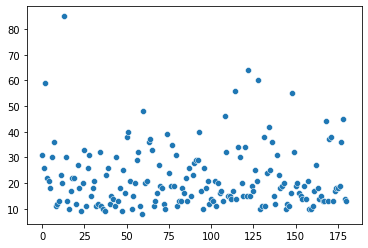

In [22]:
# plot the last 100 episode rewards
import seaborn as sns

eps_rewards = results1.best_result["hist_stats"]["episode_reward"]
eps = [i for i in range(len(eps_rewards))]
sns.scatterplot(eps, eps_rewards)


## Do Not Observe Velocity

In many practical

In [23]:
from ray.rllib.examples.env.stateless_cartpole import StatelessCartPole
from ray.tune import registry

registry.register_env("StatelessCartPole", lambda _: StatelessCartPole())
config["env"] = "StatelessCartPole"
# train; this takes a while
results_stateless = ray.tune.run("PPO", config=config, stop=stop)
print("Training finished successfully")

Trial name,status,loc
PPO_StatelessCartPole_3fb99_00000,PENDING,


(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


Trial name,status,loc
PPO_StatelessCartPole_3fb99_00000,PENDING,


(pid=22020) 2021-11-18 19:42:26,459	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=22020) 2021-11-18 19:42:26,459	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=22020) 2021-11-18 19:42:26,459	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


Trial name,status,loc
PPO_StatelessCartPole_3fb99_00000,RUNNING,127.0.0.1:22020


(pid=22020) 2021-11-18 19:42:52,675	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=22020) 2021-11-18 19:42:52,679	INFO trainable.py:110 -- Trainable.setup took 26.226 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=22020) 2021-11-18 19:42:52,681	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Trial name,status,loc
PPO_StatelessCartPole_3fb99_00000,RUNNING,127.0.0.1:22020


Trial name,status,loc
PPO_StatelessCartPole_3fb99_00000,RUNNING,127.0.0.1:22020


(pid=22020) 2021-11-18 19:42:59,809	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Trial name,status,loc
PPO_StatelessCartPole_3fb99_00000,RUNNING,127.0.0.1:22020


Trial name,status,loc
PPO_StatelessCartPole_3fb99_00000,RUNNING,127.0.0.1:22020


Result for PPO_StatelessCartPole_3fb99_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-11-18_19-43-10
  done: true
  episode_len_mean: 21.443243243243245
  episode_media: {}
  episode_reward_max: 58.0
  episode_reward_mean: 21.443243243243245
  episode_reward_min: 9.0
  episodes_this_iter: 185
  episodes_total: 185
  experiment_id: 31f6f08b96254ef6a62a190f44b25eb1
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6726511120796204
          entropy_coeff: 0.0
          kl: 0.03443628549575806
          policy_loss: -0.013767484575510025
          total_loss: 113.9546890258789
          vf_explained_var: 0.01855170540511608
          vf_loss: 113.96155548095703
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_si

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_3fb99_00000,TERMINATED,127.0.0.1:22020,1,17.6313,4000,21.4432,58,9,21.4432


(pid=22020) [2021-11-18 19:43:10,463 E 22020 22080] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=22020) Windows fatal exception: access violation
(pid=22020) 
(pid=11404) [2021-11-18 19:43:10,466 E 11404 7148] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=11404) Windows fatal exception: access violation
(pid=11404) 
(pid=21240) [2021-11-18 19:43:10,467 E 21240 9260] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=21240) Windows fatal exception: access violation
(pid=21240) 
2021-11-18 19:43:10,576	INFO tune.py:630 -- Total run time: 55.80 seconds (55.58 seconds for the tuning loop).


Training finished successfully


In [24]:
# check results
results_stateless.default_metric = "episode_reward_mean"
results_stateless.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results_stateless.best_result["episode_reward_mean"]

21.443243243243245

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

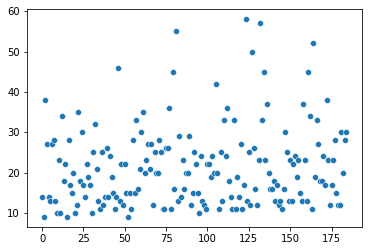

In [25]:
eps_lengths = results_stateless.best_result["hist_stats"]["episode_lengths"]
eps = [i for i in range(len(eps_lengths))]
sns.scatterplot(eps, eps_lengths)


## Stacked Observations with Attention

TODO: continue here
https://github.com/ray-project/ray/blob/master/rllib/examples/attention_net.py

> Tip: Also check out the [RLlib example using AttentionNet](https://github.com/ray-project/ray/blob/master/rllib/examples/attention_net.py).


In [26]:
config["model"] = {
    # Attention net wrapping (for tf) can already use the native keras
    # model versions. For torch, this will have no effect.
    "_use_default_native_models": True,
    "use_attention": True,
    "max_seq_len": 10,
    "attention_num_transformer_units": 1,
    "attention_dim": 32,
    "attention_memory_inference": 10,
    "attention_memory_training": 10,
    "attention_num_heads": 1,
    "attention_head_dim": 32,
    "attention_position_wise_mlp_dim": 32,
}

results_attention = ray.tune.run("PPO", config=config, stop=stop)
print("Training finished successfully")

Trial name,status,loc
PPO_StatelessCartPole_61211_00000,PENDING,


(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=18384) 2021-11-18 19:43:22,316	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=18384) 2021-11-18 19:43:22,316	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=18384) 2021-11-18 19:43:22,316	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-package

Trial name,status,loc
PPO_StatelessCartPole_61211_00000,RUNNING,127.0.0.1:18384


Trial name,status,loc
PPO_StatelessCartPole_61211_00000,RUNNING,127.0.0.1:18384


Trial name,status,loc
PPO_StatelessCartPole_61211_00000,RUNNING,127.0.0.1:18384


(pid=18384) 2021-11-18 19:43:55,725	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Trial name,status,loc
PPO_StatelessCartPole_61211_00000,RUNNING,127.0.0.1:18384


Trial name,status,loc
PPO_StatelessCartPole_61211_00000,RUNNING,127.0.0.1:18384


Result for PPO_StatelessCartPole_61211_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-11-18_19-44-06
  done: true
  episode_len_mean: 21.75409836065574
  episode_media: {}
  episode_reward_max: 74.0
  episode_reward_mean: 21.75409836065574
  episode_reward_min: 8.0
  episodes_this_iter: 183
  episodes_total: 183
  experiment_id: 54cf483dbce6432eb0784434065872bd
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6707258820533752
          entropy_coeff: 0.0
          kl: 0.025403935462236404
          policy_loss: 0.02212703600525856
          total_loss: 123.25680541992188
          vf_explained_var: 0.019463101401925087
          vf_loss: 123.22958374023438
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_sin

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_61211_00000,TERMINATED,127.0.0.1:18384,1,17.4757,4000,21.7541,74,8,21.7541


(pid=18384) [2021-11-18 19:44:06,616 E 18384 9408] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=18384) Windows fatal exception: access violation
(pid=18384) 
(pid=18620) [2021-11-18 19:44:06,635 C 18620 14528] core_worker.cc:796:  Check failed: _s.ok() Bad status: IOError: Unknown error
(pid=18620) *** StackTrace Information ***
(pid=18620)     PyInit__raylet
(pid=18620)     PyInit__raylet
(pid=18620)     PyInit__raylet
(pid=18620)     PyInit__raylet
(pid=18620)     PyInit__raylet
(pid=18620)     PyInit__raylet
(pid=18620)     PyInit__raylet
(pid=18620)     PyInit__raylet
(pid=18620)     PyInit__raylet
(pid=18620)     PyInit__raylet
(pid=18620)     PyInit__raylet
(pid=18620)     PyInit__raylet
(pid=18620)     PyInit__raylet
(pid=18620)     PyInit__raylet
(pid=18620)     PyInit__raylet
(pid=18620)     PyInit__raylet
(pid=18620)     PyNumber_InPlaceLshift
(pid=18620)     Py_CheckFunctionResult
(pid=18620)     PyEval_EvalFrameDefault
(

Training finished successfully


In [27]:
# check results
results_attention.default_metric = "episode_reward_mean"
results_attention.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results_attention.best_result["episode_reward_mean"]

21.75409836065574

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

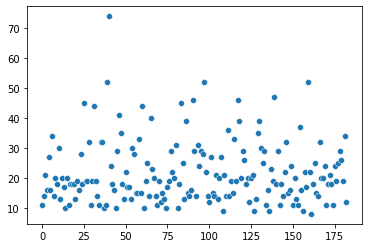

In [28]:
eps_lengths = results_attention.best_result["hist_stats"]["episode_lengths"]
eps = [i for i in range(len(eps_lengths))]
sns.scatterplot(eps, eps_lengths)

## Stateless but Stacked Frames

(maybe even with LSTM)
use `framestack = True`

